#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Rootfinding

Rootfinding is the process of solving $$f(x) = 0$$ for $x$.  The standard assumption is that $f : R \to R$ is _continuous_.  We are interested in developing general-purpose algorithms---those that can use $f(x)$ as a black box without needing to look inside.  When we implement our rootfinding algorithm in software, the user will pass a function or program to compute $f(x)$.  Rootfinding methods for differentiable functions may also use the derivative $f'(x)$.

Some questions immediately arise:
* **Existence.** When does this equation have at least one solution?
* **Uniqueness.** When is the solution unique?

Let's consider some test functions, defined here along with their derivatives which we'll use later.

<IPython.core.display.Javascript object>


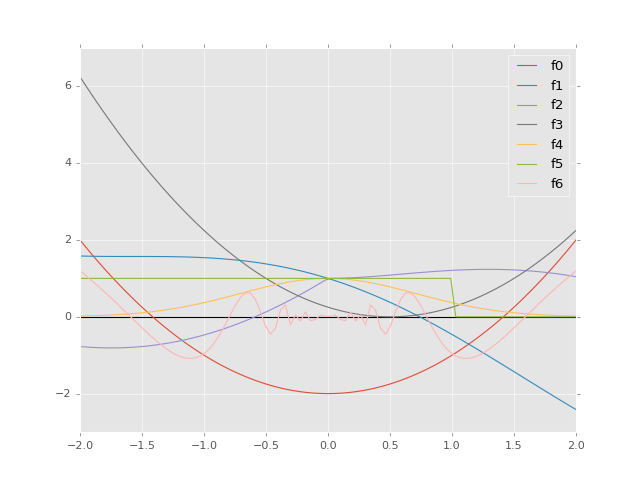

In [8]:
%matplotlib notebook
from matplotlib import pyplot
import numpy

tests = []

@tests.append
def f0(x):
    return x*x - 2, 2*x

@tests.append
def f1(x):
    return numpy.cos(x) - x, -numpy.sin(x) - 1

@tests.append
def f2(x):
    return numpy.exp(-numpy.abs(x)) + numpy.sin(x), numpy.exp(-numpy.abs(x))*(-numpy.sign(x)) + numpy.cos(x)

@tests.append
def f3(x):
    return x*x - x + 0.25, 2*x - 1

@tests.append
def f4(x):
    return numpy.exp(-x*x), numpy.exp(-x*x)*(-2*x)

@tests.append
def f5(x):
    return (x <= 1)*1.0, 0*x

@tests.append
def f6(x):
    return x*numpy.sin(5/x), 0

x = numpy.linspace(-2,2,100)
pyplot.plot(x, 0*x, color='k')
for f in tests:
    pyplot.plot(x, f(x)[0], label=f.__name__)
pyplot.legend(loc='upper right')
pyplot.style.use('ggplot')
pyplot.show()

* Which of these functions have at least one root?
* Which have more than one root?
* Can we determine these properties merely by evaluating $f(x)$ for some values of $x$?

## Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives.

In [2]:
def hasroot(f, a, b):
    return f(a)[0]*f(b)[0] < 0
    
def bisect(f, a, b, verbose=False):
    mid = (a + b)/2.
    if b-a < 1e-5:
        return mid
    if verbose:
        print('bisect', mid)
    if hasroot(f, a, mid):
        return bisect(f, a, mid, verbose)
    else:
        return bisect(f, mid, b, verbose)

* Notice that we need to define `hasroot` above.

Let's try running it:

In [3]:
bisect(tests[0], 0, 2)

1.4142112731933594

In [4]:
numpy.sqrt(2) - bisect(tests[0], 0, 2)

2.2891797357704746e-06

We get about 5 digits of accuracy.  Why?  How fast did we get there?

In [5]:
bisect(tests[0], 0, 2, verbose=True)

bisect 1.0
bisect 1.5
bisect 1.25
bisect 1.375
bisect 1.4375
bisect 1.40625
bisect 1.421875
bisect 1.4140625
bisect 1.41796875
bisect 1.416015625
bisect 1.4150390625
bisect 1.41455078125
bisect 1.414306640625
bisect 1.4141845703125
bisect 1.41424560546875
bisect 1.414215087890625
bisect 1.4141998291015625
bisect 1.4142074584960938


1.4142112731933594

Can you find any problems with this implementation?  List them below:

* No error checking
* Can "converge" to nonsense
* Recursion is bad in Python
* Doesn't handle ill-defined points (function value not available)
* Evaluates $f(x)$ more than necessary (multiple times at the same point)

Let's try running it on the rest of the test problem set:

In [6]:
for f in tests:
    print(f.__name__, bisect(f, -2, 2.1))

f0 -1.4142136573791504
f1 0.7390824317932131
f2 -0.588533115386963
f3 2.0999960899353027
f4 2.0999960899353027
f5 2.0999960899353027
f6 -1.5915507316589355


What's going wrong here?  How can we improve the implementation and what are fundamental limitations of the algorithm?

### Convergence rate

Let's quantitatively revisit the convergence rate.  A convergent rootfinding algorithm produces a sequence of approximations $x_i$ such that $$\lim_{i \to \infty} x_i \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_i = x_i - x_*$. We say that an algorithm is **linearly convergent** if $$\lim_{i \to \infty} |e_{i+1}| / |e_i| = \rho < 1.$$  A smaller convergence factor $\rho$ represents faster convergence.

What is $\rho$ for bisection?

### Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* The solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \dotsb $$
centered on some reference point $x_0$.
In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

In [7]:
def newton(f, x):
    for i in range(100):
        fx, dfx = f(x)
        if numpy.abs(fx) < 1e-12:
            return x, fx, i
        x -= fx / dfx

for f in tests:
    print(f.__name__, newton(f, 0.1))

f0 (1.4142135623730956, 1.3322676295501878e-15, 8)
f1 (0.73908513321516067, 0.0, 5)
f2 (-31.415926535897967, -1.1591479305617497e-14, 6)
f3 (0.4999992370620596, 5.820621762353539e-13, 19)
f4 (5.2942293326232788, 6.7176741266169553e-13, 3)


ZeroDivisionError: float division by zero

* Oops, how can we fix this?
* This output is kinda hard to read, so let's make it cleaner.

In [11]:
for f in tests:
    print(f.__name__, '{0:15.12f} {1:8.2e} {2:2d}'.format(*newton(f, -0.1)))

f0 -1.414213562373 1.33e-15  8
f1  0.739085133215 0.00e+00  5
f2 -0.588532743981 5.55e-13  4
f3  0.499999427800 3.27e-13 20
f4 -5.294229332623 6.72e-13  3


ZeroDivisionError: float division by zero

* Did we solve all of these equations?
* How can the iteration break down?
* Does choosing a different initial guess lead to different solutions?
* How is this convergence test different from the one we used for bisection?
* Is the convergence rate similar for all test equations?

## Convergence of Newton-type algorithms

We would like to know sharp conditions on when Newton-type algorithms converge, and if so, how fast.  This theory will build on that for a general _Fixed Point Iteration_ $x_{i+1} = g(x_i)$ where $g$ is a continuously differentiable function.  Suppose that there exists a fixed point $r = g(r)$.  By the mean value theorem, we have that
$$ x_{i+1} - r = g(x_i) - g(r) = g'(c_i) (x_i - r) $$
for some $c$ with $|c - r| < |x_i - r|$.
In other words, $|e_{i+1}| = |g'(c_i)| |e_i|$, which converges to zero if $|g'(c_i)| < 1$.
If $|g'(r)| < 1$ then for any $\epsilon > 0$ there is a neighborhood of $r$ such that $|g'(c)| < |g'(r)| + \epsilon$ for all $c$ in that neighborhood.
Consequently, we have:

#### Theorem (Sauer 1.6): Linear Convergence of Fixed Point Iteration

If $g$ is continuously differentiable, $r = g(r)$, and $|g'(r)| < 1$ then the fixed point iteration $x_{i+1} = g(x_i)$ is locally linearly convergent with rate $|g'(r)|$.

#### Observations

* A rootfinding problem $f(x) = 0$ can be converted to a fixed point problem $x = x - f(x) =: g(x)$ but there is no guarantee that $g'(r) = 1 - f'(r)$ will have magnitude less than 1.
* Problem-specific algebraic manipulation can be used to make $|g'(r)|$ small.
* $x = x - h(x)f(x)$ is also a valid formulation for any $h(x)$ bounded away from $0$.
* Can we choose $h(x)$ such that $ 1 - h'(x)f(x) - h(x)f'(x) = 0$ when $f(x) = 0$?

In other words,
$$ x_{i+1} = x_i - ??? . $$

* It turns out that Newton's method has _locally quadratic_ convergence to simple roots, $\lim_{i \to \infty} |e_{i+1}|/|e_i^2| < \infty$.
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

#### Culture: fast inverse square root

The following code appeared literally (including comments) in the Quake III Arena source code (late 1990s).

```C
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck? 
	y  = * ( float * ) &i;
	y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//	y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}
```

We now have [vector instructions](https://software.intel.com/sites/landingpage/IntrinsicsGuide/#text=sqrt&expand=2989,1224,4470) for approximate inverse square root.
More at https://en.wikipedia.org/wiki/Fast_inverse_square_root

## Conditioning


In [18]:
def fquartic(x):
    return (x - 0.9)**4, 4*(x - 0.9)**3

newton(fquartic, 0)

(0.899096947850202, 6.650454451607741e-13, 24)

We only get three digits correct despite a very small residual (and it takes many iterations to get there).
Difficulty computing zeros of polynomials can also arise when all the roots are simple.  For example, the Wilkinson polynomial
$$ \product_{i=1}^20 (x - i) = \sum_{i=0}^20 a_i x^i $$
has roots at each of the positive integers up to 20, but the roots are extremely sensitive to perturbations of the coefficients $a_i$, as shown in this figure from Trefethen and Bau (1999).
![Ill conditioning of roots of Wilkinson's polynomial](TB-Wilkinson.png)

Numerical difficulties in which "correct" algorithms produce unreliable solutions almost always stem from lack of *stability* and/or *ill conditioning*.

### Absolute condition number
Consider a function $f: X \to Y$ and define the *absolute condition number*
$$ \kappa = \lim_{\delta \to 0} \max_{|\delta x| < \delta} \frac{|f(x + \delta x) - f(x)|}{|\delta x|} = \max_{\delta x} \frac{|\delta f|}{|\delta x|}. $$
If $f$ is differentiable, then $\kappa = |f'(x)|$.

### Floating point arithmetic
Floating point arithmetic $x \circledast y := \text{float}(x * y)$ is exact within a relative accuracy $\epsilon_{\text{machine}}$.  Formally,
$$ x \circledast y = (x * y) (1 + \epsilon) $$
for some $|\epsilon| \le \epsilon_{\text{machine}}$.